In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def swift_voce(strain, alpha, A, epsilon_0, n, k0, Q, beta):
        swift_term = alpha * A * (epsilon_0 + strain) ** n
        voce_term = (1 - alpha) * (k0 + Q * (1 - np.exp(-beta * strain)))
        return swift_term + voce_term


def modified_swift_voce(strain, A, B, n, Q, epsilon0, alpha, beta):
        swift_part = A * (strain + epsilon0) ** n  # Swift law
        voce_part = Q * (1 - np.exp(-B * strain))  # Voce law
        damping = (1 - np.exp(-alpha * strain)) / (1 + beta * strain)  # Damping term
        return swift_part + voce_part * damping

def r_value(strain, c1, c2, c3):
        return c1 + c2 * (1-np.exp(-c3 * strain))


# Normal Swift-Voce fitting

In [3]:
def analyze_sv_fit(file_path, strain_column, stress_column, title, initial_guess=None):
# Load data in
    data = pd.read_csv(file_path)
    strain = data[strain_column].dropna().values
    stress = data[stress_column].dropna().values
    
# Initial guesses for parameters [alpha, A, epsilon_0, n, k0, Q, beta]
    initial_guess = [0.5, 500, 0.01, 0.2, 300, 200, 10]
    
# Fit the curve with bounds
    params, _ = curve_fit(swift_voce, strain, stress, p0=initial_guess, maxfev=100000)

# Extract fitted parameters
    alpha, A, epsilon_0, n, k0, Q, beta = params

# Plot the experimental data and the fitted curve
    fitted_stress = swift_voce(strain, *params)
    plt.scatter(strain, stress, label='Experimental Data', color='red')
    plt.plot(strain, fitted_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xlim(left=0)
    plt.ylim(bottom=min(fitted_stress))
    plt.show()

# Print fitted parameters
    print(f'Fitted Parameters:\nAlpha: {alpha:.4f}\nA: {A:.4f}\nEpsilon_0: {epsilon_0:.4f}\n'
      f'n: {n:.4f}\nK0: {k0:.4f}\nQ: {Q:.4f}\nBeta: {beta:.4f}\n')
    
# Calculate error metrics
    mse = np.mean((stress - fitted_stress) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(stress - fitted_stress))
    r_squared = 1 - np.sum((stress - fitted_stress) ** 2) / np.sum((stress - np.mean(stress)) ** 2)

    # Print error metrics
    print(f'Error Metrics:\n'
          f'MSE: {mse:.4f}\n'
          f'RMSE: {rmse:.4f}\n'
          f'MAE: {mae:.4f}\n'
          f'R-squared: {r_squared:.4f}')
    
# Extended strain for comparison (you might want to adjust this range)
    extended_strain = pd.read_csv("data/strain_extended.csv")['strain']
    extended_strain = extended_strain[extended_strain <= 1.5]
    extended_stress = swift_voce(extended_strain, *params)
    plt.scatter(strain, stress, label='Experimental Data', color='red', s=10)
    plt.plot(extended_strain, extended_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(f"{title}_extended")
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=min(fitted_stress))
    plt.show()
    
    
    # Create a DataFrame to save the results
    df = pd.DataFrame({
        'Strain': extended_strain,
        'Stress': extended_stress
    })

    # Save the DataFrame to a CSV file
    '''
    output_file_path = f"extended_curve/{title}.csv"  # Adjust the filename as needed
    df.to_csv(output_file_path, index=False)
    '''

    return params, extended_stress, extended_strain
   

# Modified Swift-Voce fitting with damping value for high strain

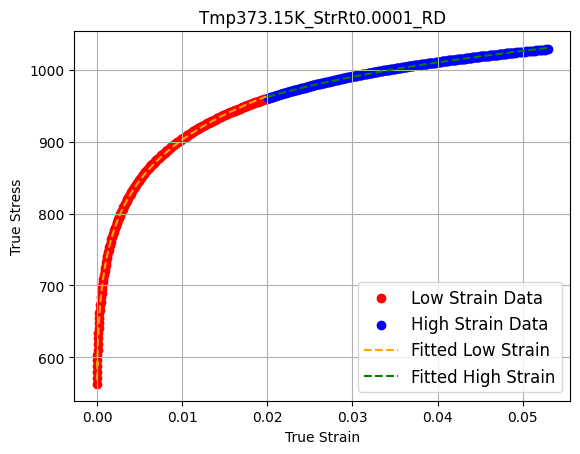

Fitted Parameters for Low Strain (<0.02):
A: 1395.9766, B: 1.7693, n: 0.0949, Q: 1303.1372, Epsilon_0: 0.0001, Alpha: 0.0000, Beta: 19.9967
Fitted Parameters for High Strain (>=0.02):
A: 1266.8985, B: 12.7198, n: 0.0703, Q: 501.4569, Epsilon_0: 0.0000, Alpha: 0.0000, Beta: 0.6675


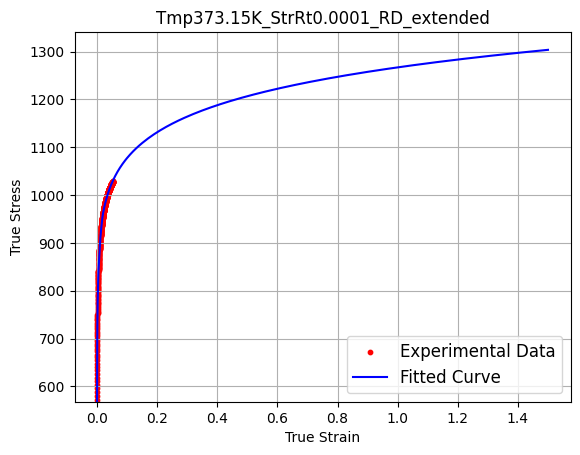

(array([1.39597659e+03, 1.76931806e+00, 9.48876435e-02, 1.30313719e+03,
        7.66198392e-05, 1.69670152e-09, 1.99967423e+01]),
 array([1.26689846e+03, 1.27197767e+01, 7.03059299e-02, 5.01456910e+02,
        2.77464942e-17, 8.12437040e-20, 6.67517755e-01]))

In [4]:
def analyze_msv_fit(file_path, strain_column, stress_column, title, initial_guess=None):
    # Load data
    data = pd.read_csv(file_path)
    strain = data[strain_column].dropna().values
    stress = data[stress_column].dropna().values
    
    # Initial guesses for parameters [A, B, n, K, epsilon0, alpha, beta]
    if initial_guess is None:
        initial_guess = [1500, 20, 0.2, 2000, 0.02, 0.3, 5] # Default values if not provided
    
    # Adjusted bounds to limit parameter values
    bounds = ([500, 0, 0, 500, 0, 0, 0], [5000, 50, 1, 5000, 0.2, 1, 20])

    # Separate data into low and high strain regions
    low_strain = strain[strain < 0.02]
    low_stress = stress[strain < 0.02]

    high_strain = strain[strain >= 0.02]
    high_stress = stress[strain >= 0.02]

    # Fit the curve for low strain data
    params_low, _ = curve_fit(
        modified_swift_voce, low_strain, low_stress, p0=initial_guess, bounds=bounds
    )

    # Fit the curve for high strain data
    params_high, _ = curve_fit(
        modified_swift_voce, high_strain, high_stress, p0=initial_guess, bounds=bounds
    )

    # Extract fitted stress values
    fitted_low_stress = modified_swift_voce(low_strain, *params_low)
    fitted_high_stress = modified_swift_voce(high_strain, *params_high)

    # Plot experimental and fitted curves
    plt.scatter(low_strain, low_stress, label='Low Strain Data', color='red')
    plt.scatter(high_strain, high_stress, label='High Strain Data', color='blue')
    plt.plot(low_strain, fitted_low_stress, color='orange', linestyle='--', label='Fitted Low Strain')
    plt.plot(high_strain, fitted_high_stress, color='green', linestyle='--', label='Fitted High Strain')
    
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(title)
    plt.legend(fontsize='large')
    plt.grid(True)
    plt.show()

    # Print fitted parameters for both regions
    print(f'Fitted Parameters for Low Strain (<0.02):\n'
          f'A: {params_low[0]:.4f}, B: {params_low[1]:.4f}, n: {params_low[2]:.4f}, '
          f'Q: {params_low[3]:.4f}, Epsilon_0: {params_low[4]:.4f}, '
          f'Alpha: {params_low[5]:.4f}, Beta: {params_low[6]:.4f}')

    print(f'Fitted Parameters for High Strain (>=0.02):\n'
          f'A: {params_high[0]:.4f}, B: {params_high[1]:.4f}, n: {params_high[2]:.4f}, '
          f'Q: {params_high[3]:.4f}, Epsilon_0: {params_high[4]:.4f}, '
          f'Alpha: {params_high[5]:.4f}, Beta: {params_high[6]:.4f}')

    extended_strain = pd.read_csv("data/strain_extended.csv")['strain']
    extended_strain = extended_strain[extended_strain <= 1.5]
    low_stress = modified_swift_voce(extended_strain[extended_strain < 0.02], *params_low)
    high_stress = modified_swift_voce(extended_strain[extended_strain >= 0.02], *params_high)
    extended_stress = np.concatenate((low_stress, high_stress))
    plt.scatter(strain, stress, label='Experimental Data', color='red', s=10)
    plt.plot(extended_strain, extended_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(f"{title}_extended")
    plt.legend(fontsize='large')
    plt.ylim(bottom=min(extended_stress))
    plt.grid(True)
    plt.show()
    
    '''
    # Create a DataFrame to save the results
    df = pd.DataFrame({
        'Strain': extended_strain,
        'Stress': extended_stress
    })

    # Save the DataFrame to a CSV file
    output_file_path = f"extended_curve/{title}.csv"  # Adjust the filename as needed
    df.to_csv(output_file_path, index=False)
    '''
    return params_low, params_high
   
condition = 'Tmp298.15K_StrRt1_RD'
#condition = 'Tmp473.15K_StrRt0.1_RD'
condition = 'Tmp373.15K_StrRt0.0001_RD'
analyze_msv_fit('data/Exp_FC_StrRtDpn_TmpDpn_Tmp373.csv', condition + '_E', condition + '_S', condition)



# Plot of all strain rate and parameters relationship

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


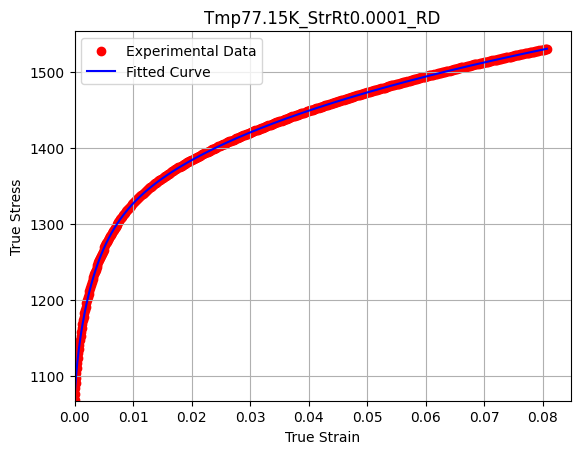

Fitted Parameters:
Alpha: 0.3583
A: 2543.0377
Epsilon_0: 0.0001
n: 0.3082
K0: 1579.4726
Q: 151.6892
Beta: 295.7148

Error Metrics:
MSE: 0.1312
RMSE: 0.3623
MAE: 0.2672
R-squared: 1.0000


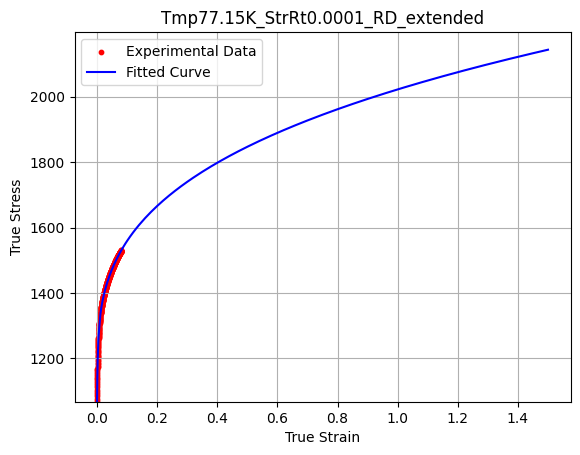

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


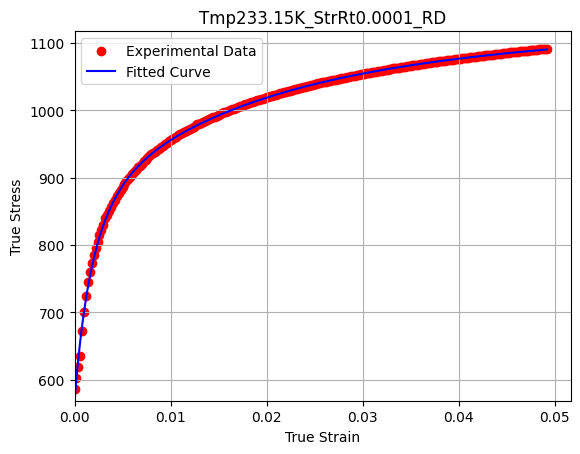

Fitted Parameters:
Alpha: -0.0089
A: 663.4194
Epsilon_0: 0.0033
n: -0.8679
K0: 1402.8312
Q: -246.5525
Beta: 181.8404

Error Metrics:
MSE: 5.6107
RMSE: 2.3687
MAE: 0.9970
R-squared: 0.9994


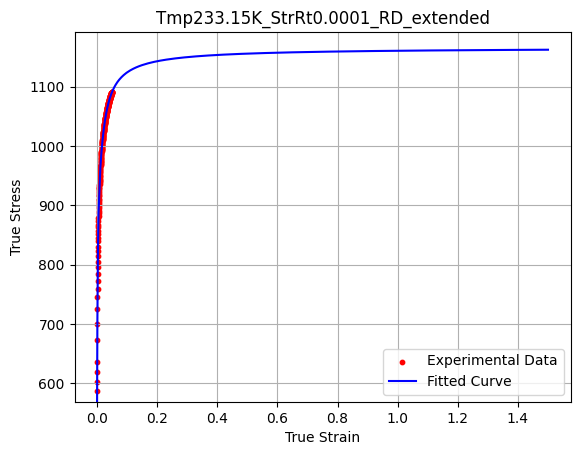

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


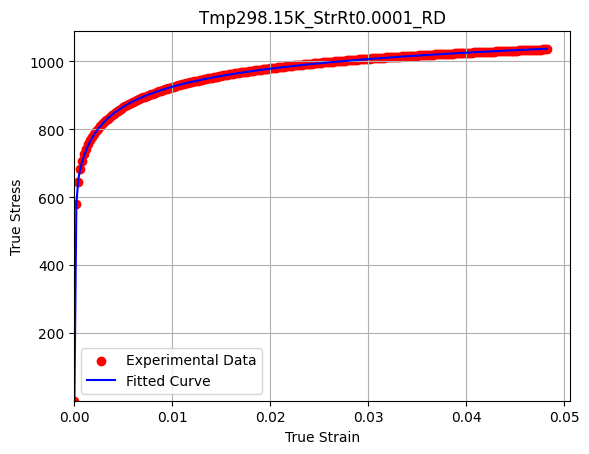

Fitted Parameters:
Alpha: -0.0843
A: 1855.4915
Epsilon_0: 0.0005
n: -0.2100
K0: 699.9021
Q: 528.6419
Beta: 12990.0817

Error Metrics:
MSE: 1.8040
RMSE: 1.3431
MAE: 1.0403
R-squared: 0.9998


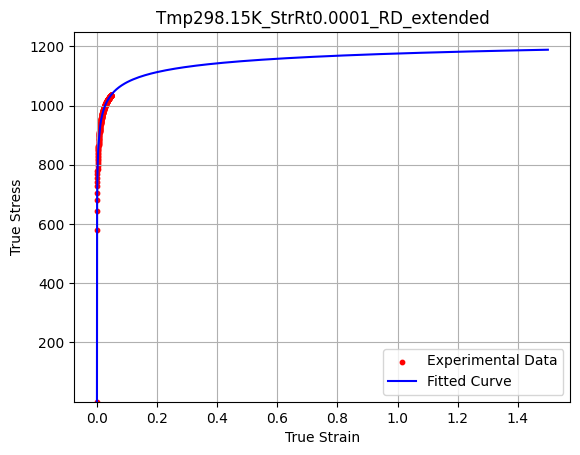

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


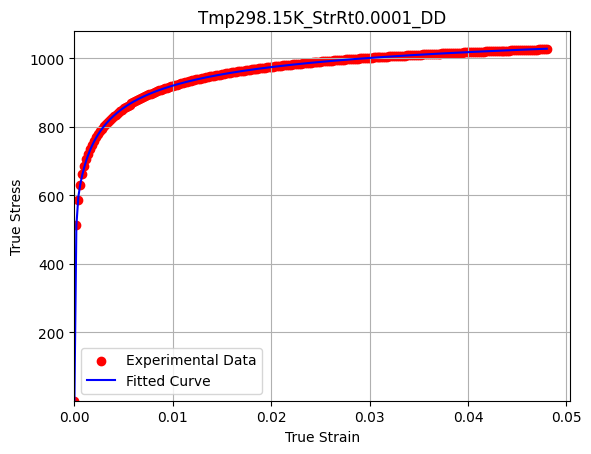

Fitted Parameters:
Alpha: -0.0351
A: 1449.0665
Epsilon_0: 0.0007
n: -0.3575
K0: 654.2613
Q: 482.9348
Beta: 11932.3490

Error Metrics:
MSE: 1.3216
RMSE: 1.1496
MAE: 0.7950
R-squared: 0.9999


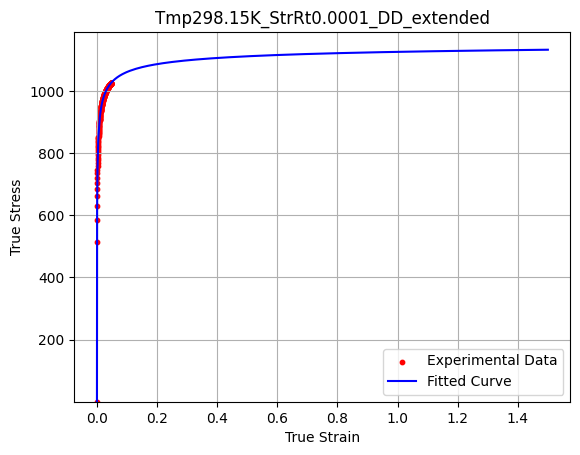

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


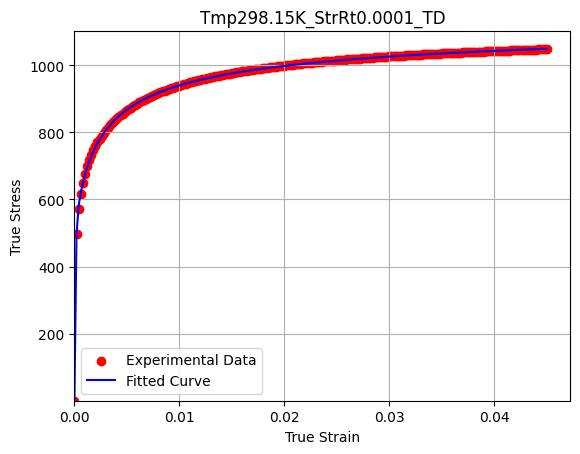

Fitted Parameters:
Alpha: -0.0162
A: 1859.3901
Epsilon_0: 0.0010
n: -0.4505
K0: 670.9988
Q: 480.5649
Beta: 11558.5423

Error Metrics:
MSE: 1.7418
RMSE: 1.3198
MAE: 0.9458
R-squared: 0.9999


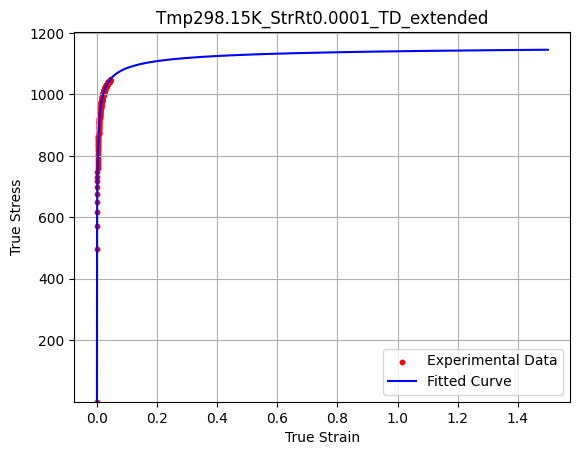

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


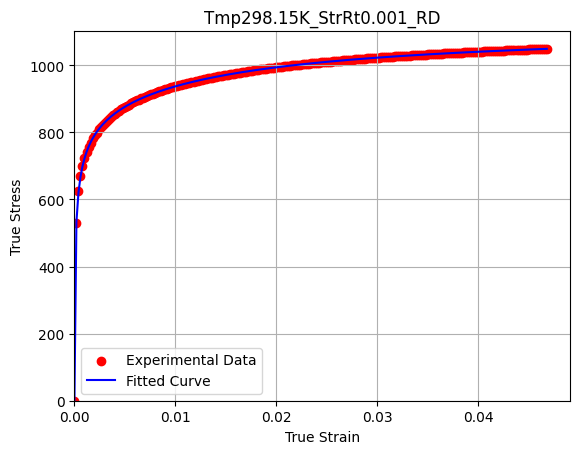

Fitted Parameters:
Alpha: -0.1499
A: 829.4386
Epsilon_0: 0.0000
n: -0.2021
K0: 1059.8279
Q: 54.5216
Beta: 76.6431

Error Metrics:
MSE: 0.2956
RMSE: 0.5437
MAE: 0.2610
R-squared: 1.0000


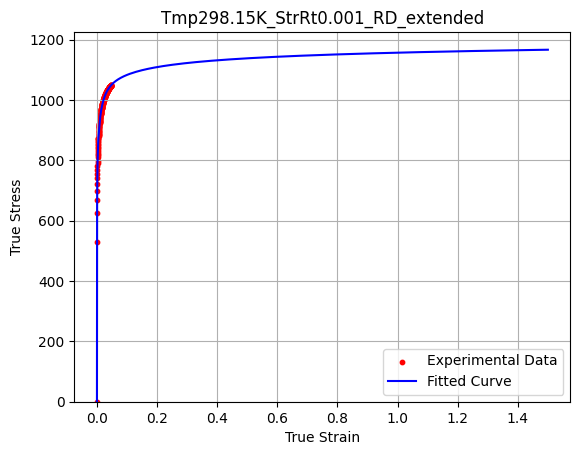

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


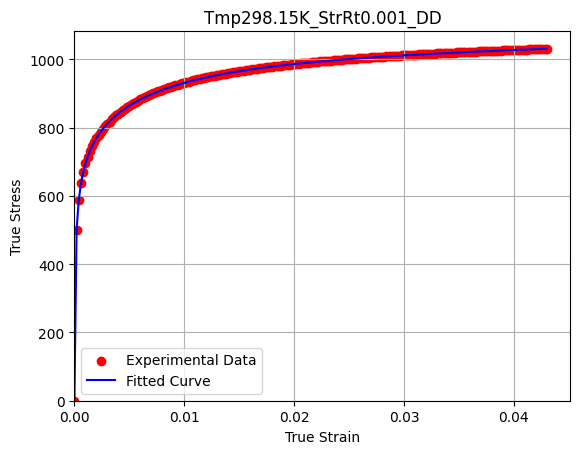

Fitted Parameters:
Alpha: -0.1696
A: 896.9352
Epsilon_0: 0.0000
n: -0.1862
K0: 1054.5637
Q: 61.0253
Beta: 156.4644

Error Metrics:
MSE: 0.0724
RMSE: 0.2691
MAE: 0.2127
R-squared: 1.0000


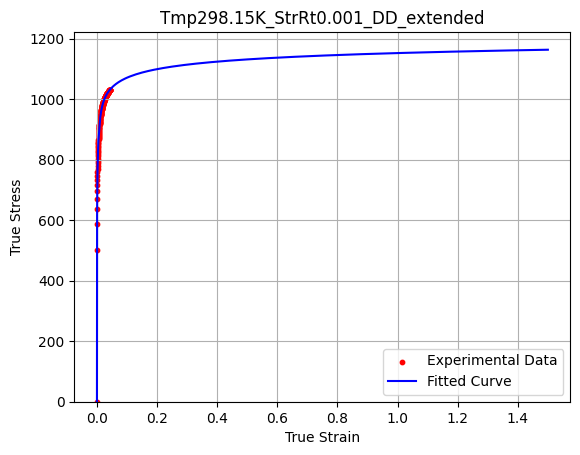

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


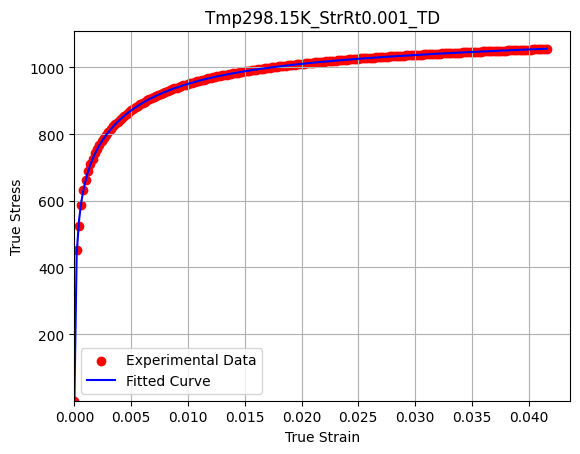

Fitted Parameters:
Alpha: -0.1573
A: 898.7127
Epsilon_0: 0.0000
n: -0.2040
K0: 1053.6354
Q: 92.6702
Beta: 201.5890

Error Metrics:
MSE: 2.3568
RMSE: 1.5352
MAE: 0.5065
R-squared: 0.9998


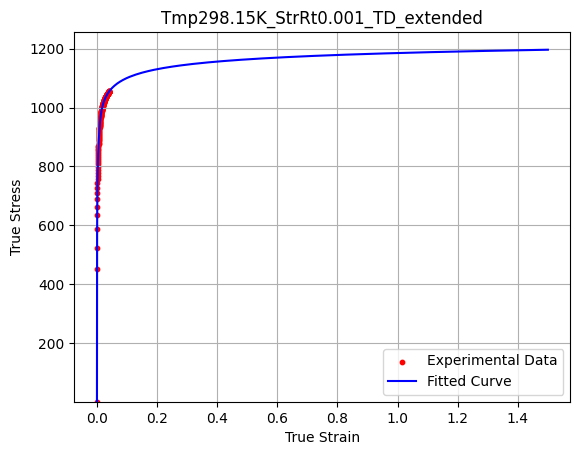

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


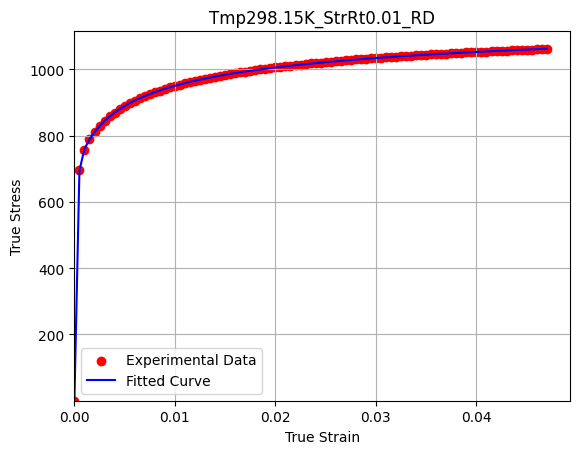

Fitted Parameters:
Alpha: -0.0412
A: 1528.7965
Epsilon_0: 0.0017
n: -0.3426
K0: 538.6508
Q: 652.1925
Beta: 6113.3657

Error Metrics:
MSE: 0.2257
RMSE: 0.4751
MAE: 0.3518
R-squared: 1.0000


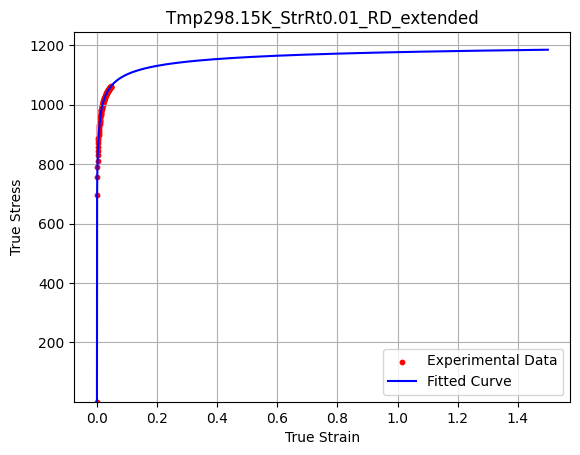

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


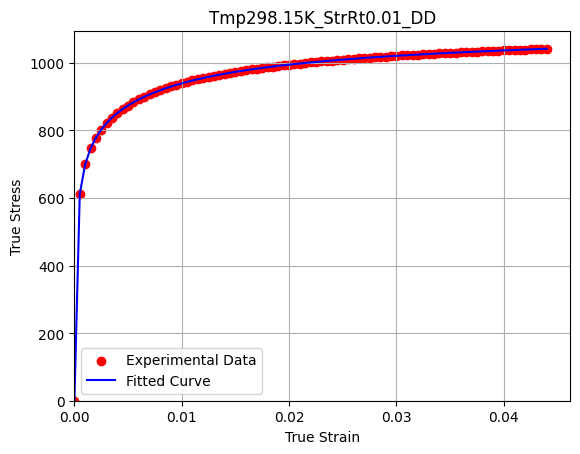

Fitted Parameters:
Alpha: -0.1439
A: 786.6893
Epsilon_0: 0.0000
n: -0.2221
K0: 1062.3852
Q: 46.3042
Beta: 130.3721

Error Metrics:
MSE: 0.2331
RMSE: 0.4828
MAE: 0.2647
R-squared: 1.0000


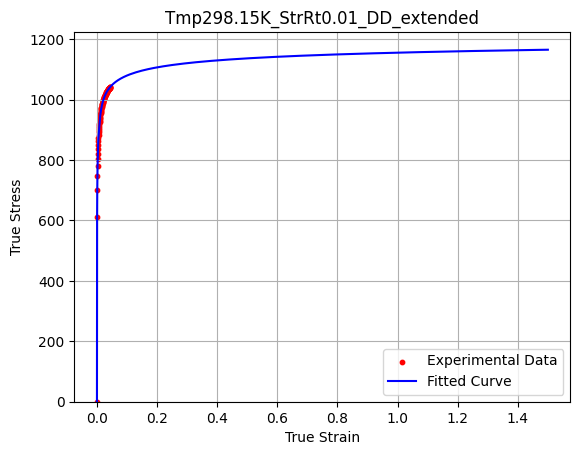

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


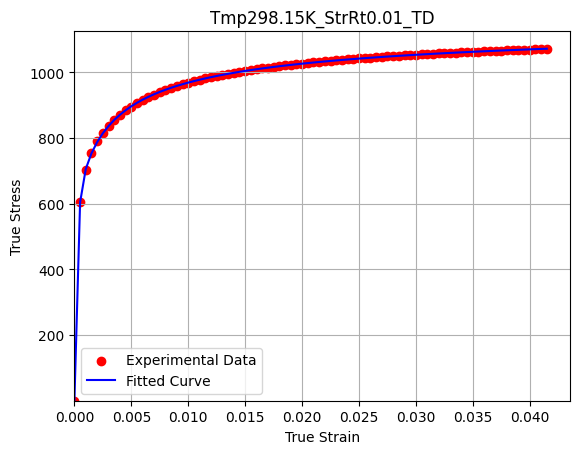

Fitted Parameters:
Alpha: -0.0142
A: 1595.8106
Epsilon_0: 0.0013
n: -0.4994
K0: 620.4402
Q: 543.5982
Beta: 5095.2831

Error Metrics:
MSE: 0.4123
RMSE: 0.6421
MAE: 0.4282
R-squared: 1.0000


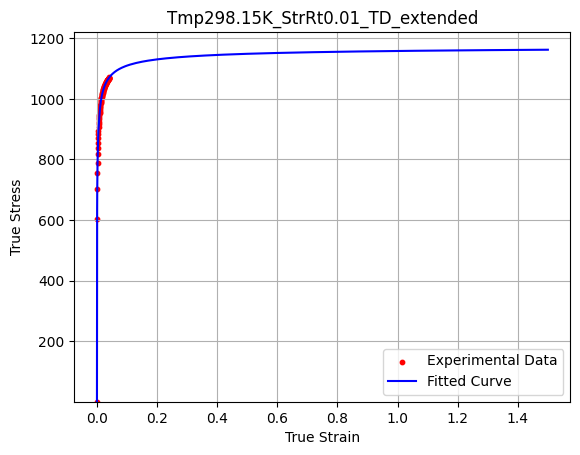

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


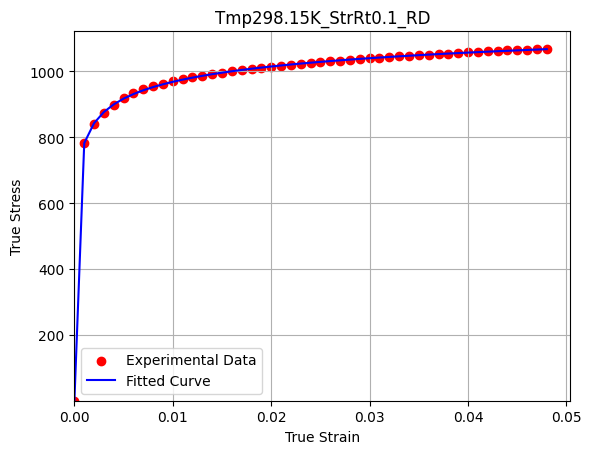

Fitted Parameters:
Alpha: -0.1833
A: 1344.1183
Epsilon_0: 0.0001
n: -0.1469
K0: 799.7405
Q: 427.7758
Beta: 12388.0087

Error Metrics:
MSE: 1.3047
RMSE: 1.1422
MAE: 0.9157
R-squared: 0.9999


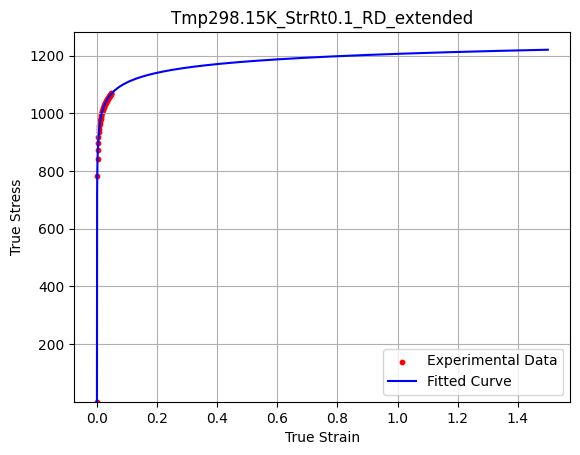

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


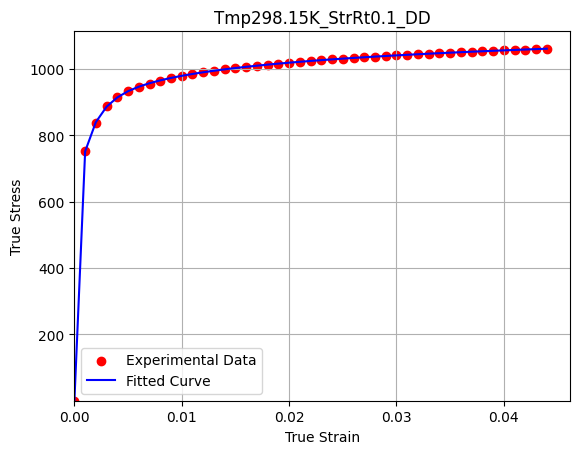

Fitted Parameters:
Alpha: -0.2393
A: 1821.1632
Epsilon_0: 0.0000
n: -0.0894
K0: 1192.5889
Q: 128.4945
Beta: 718.7260

Error Metrics:
MSE: 0.6722
RMSE: 0.8199
MAE: 0.3893
R-squared: 1.0000


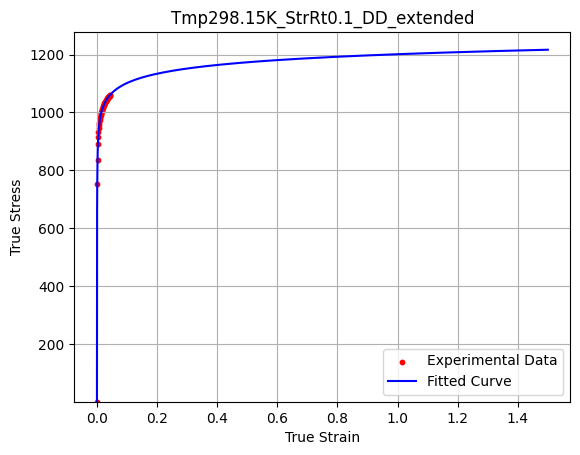

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


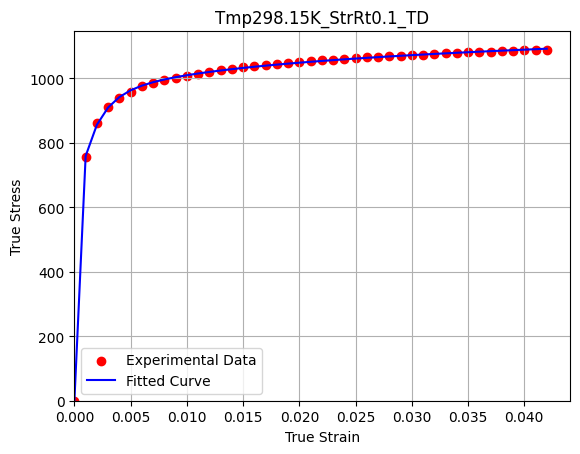

Fitted Parameters:
Alpha: 0.8197
A: 1290.7194
Epsilon_0: 0.0000
n: 0.0709
K0: -60.3743
Q: 1426.2732
Beta: 638.7484

Error Metrics:
MSE: 3.2585
RMSE: 1.8051
MAE: 1.4837
R-squared: 0.9999


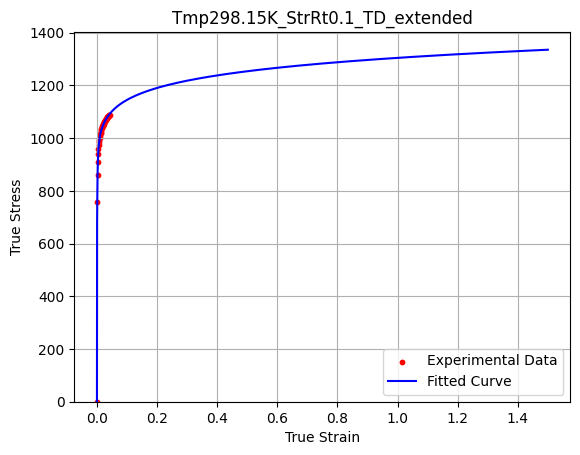

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


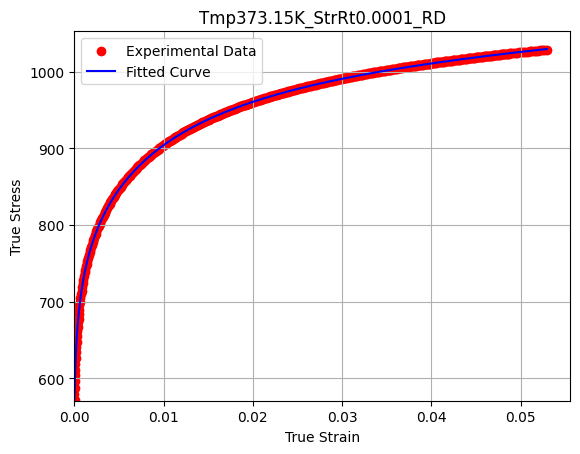

Fitted Parameters:
Alpha: 0.4585
A: 112243.4916
Epsilon_0: 0.0001
n: 0.0013
K0: -92892.4490
Q: 95.4746
Beta: 116.5589

Error Metrics:
MSE: 1.1108
RMSE: 1.0539
MAE: 0.4279
R-squared: 0.9999


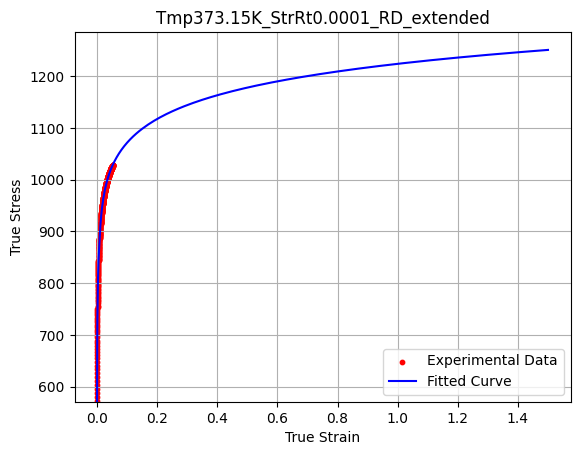

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


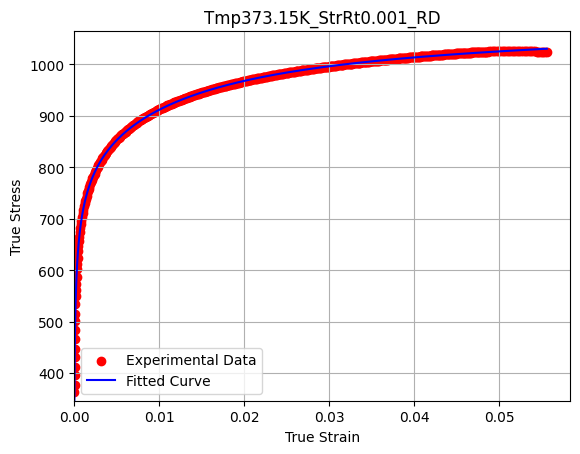

Fitted Parameters:
Alpha: -0.1988
A: 770.0644
Epsilon_0: 0.0000
n: -0.1730
K0: 1010.4073
Q: 60.2026
Beta: 80.0389

Error Metrics:
MSE: 5.8581
RMSE: 2.4203
MAE: 1.1417
R-squared: 0.9995


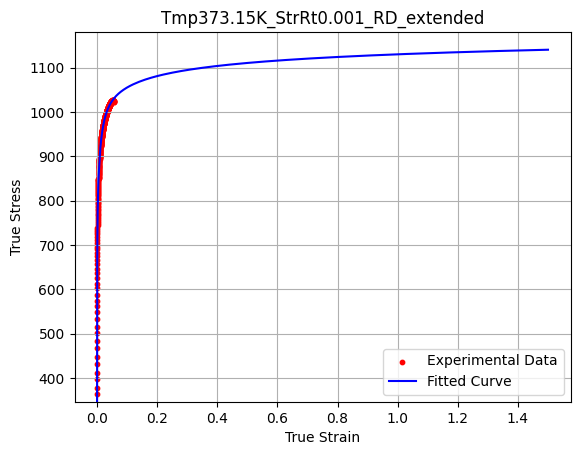

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


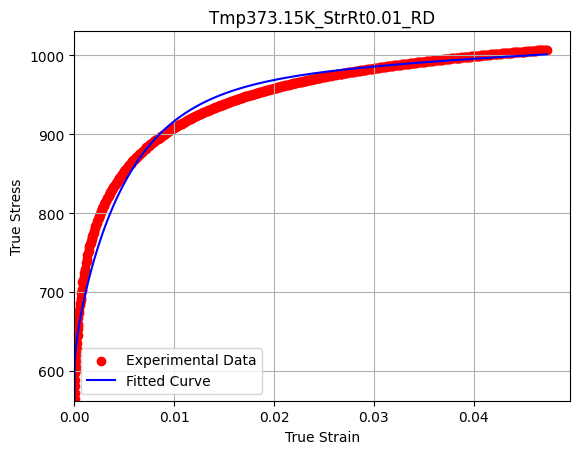

Fitted Parameters:
Alpha: 0.2733
A: 1153.5257
Epsilon_0: 0.0000
n: 0.1891
K0: 773.1665
Q: 361.2355
Beta: 188.8087

Error Metrics:
MSE: 206.8467
RMSE: 14.3822
MAE: 10.2384
R-squared: 0.9784


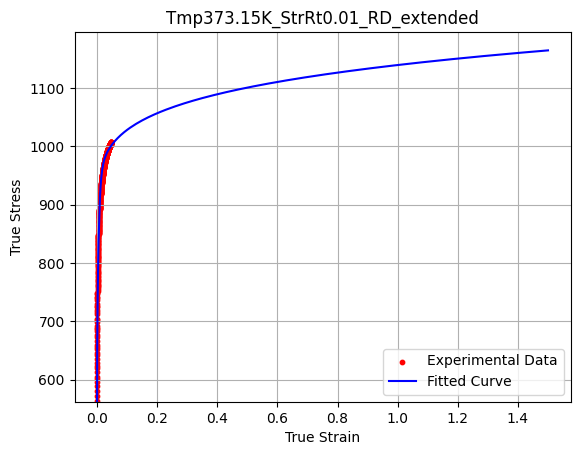

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


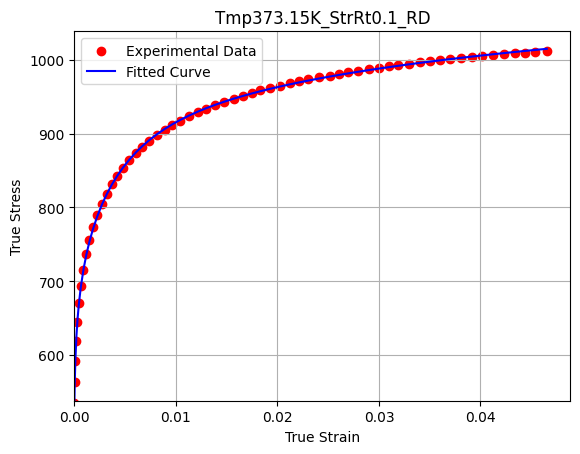

Fitted Parameters:
Alpha: 0.4535
A: 636033.4082
Epsilon_0: 0.0001
n: 0.0002
K0: -525795.9677
Q: 143.4420
Beta: 256.6019

Error Metrics:
MSE: 3.4534
RMSE: 1.8583
MAE: 1.3718
R-squared: 0.9998


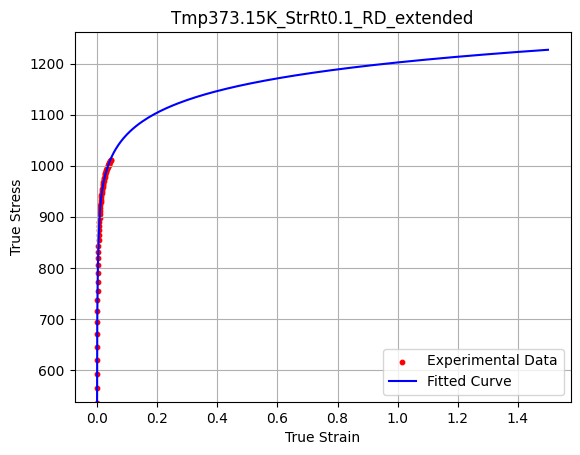

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


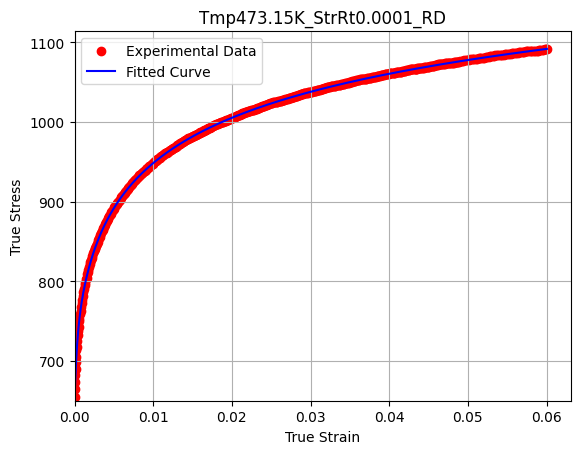

Fitted Parameters:
Alpha: -0.6569
A: 945.1661
Epsilon_0: 0.0010
n: -0.0951
K0: 1115.2316
Q: 32.6088
Beta: 3846.0960

Error Metrics:
MSE: 0.3515
RMSE: 0.5929
MAE: 0.3510
R-squared: 1.0000


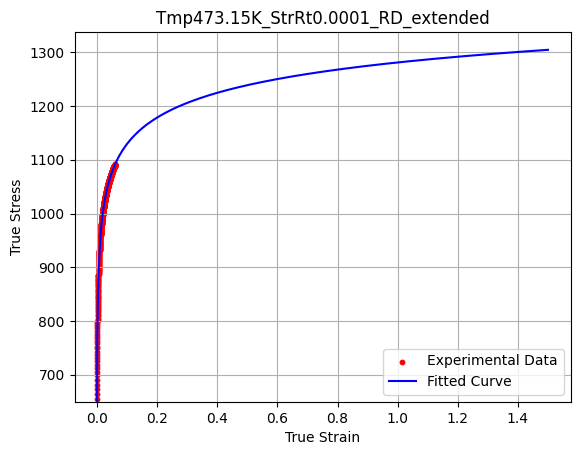

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


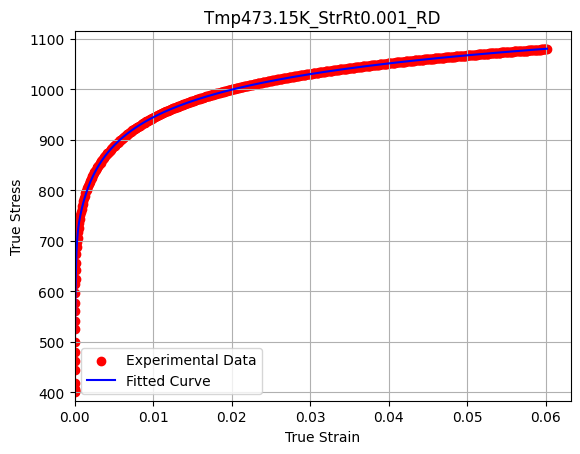

Fitted Parameters:
Alpha: -0.2774
A: 1598.2446
Epsilon_0: 0.0007
n: -0.1154
K0: 1099.9196
Q: 224.9210
Beta: 9459.2155

Error Metrics:
MSE: 34.6298
RMSE: 5.8847
MAE: 1.3485
R-squared: 0.9974


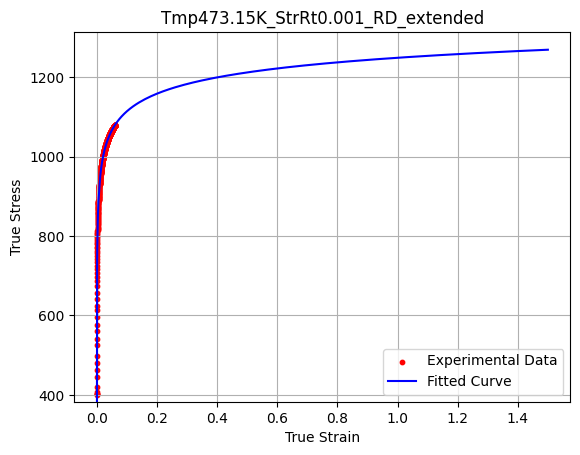

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


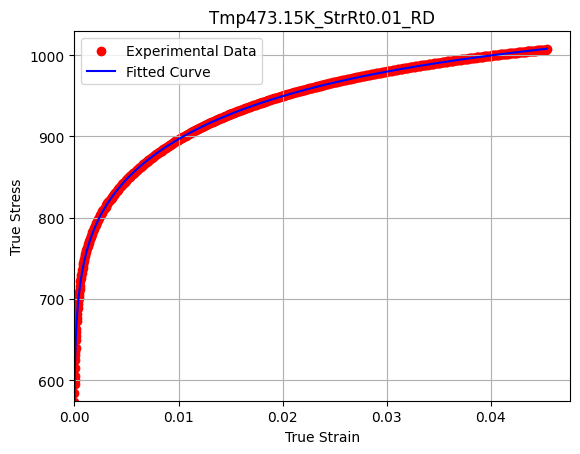

Fitted Parameters:
Alpha: 0.4668
A: 606504.1699
Epsilon_0: 0.0000
n: 0.0002
K0: -528942.4127
Q: 121.1288
Beta: 62.8999

Error Metrics:
MSE: 1.0657
RMSE: 1.0323
MAE: 0.5664
R-squared: 0.9999


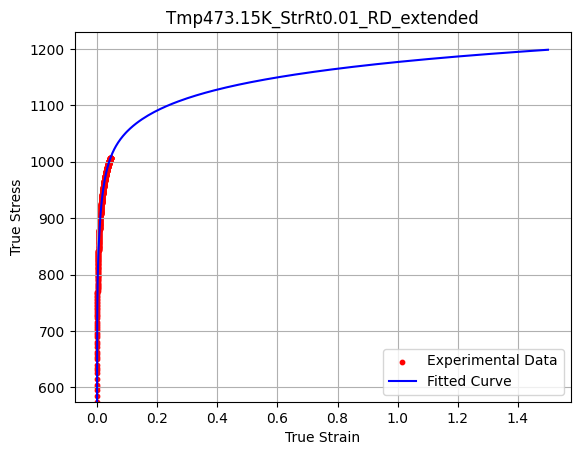

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


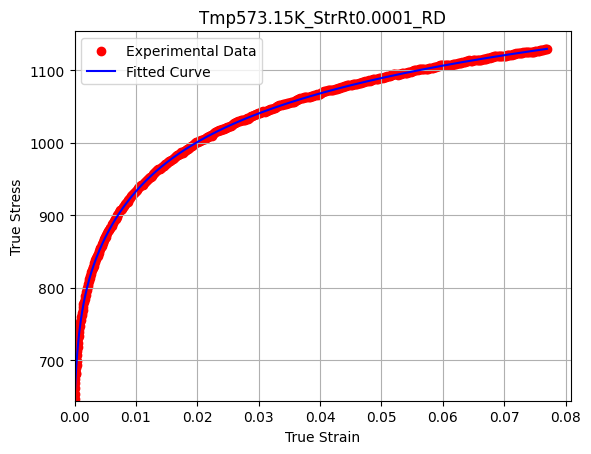

Fitted Parameters:
Alpha: -1.2641
A: 1075.9454
Epsilon_0: 0.0005
n: -0.0589
K0: 1222.8052
Q: -25.3908
Beta: 465.0636

Error Metrics:
MSE: 1.2864
RMSE: 1.1342
MAE: 0.7567
R-squared: 0.9999


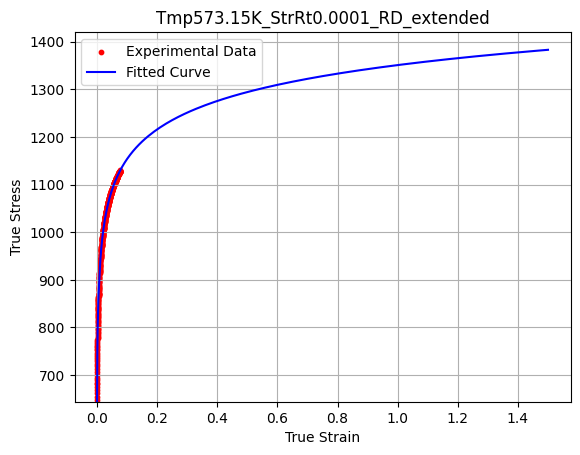

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


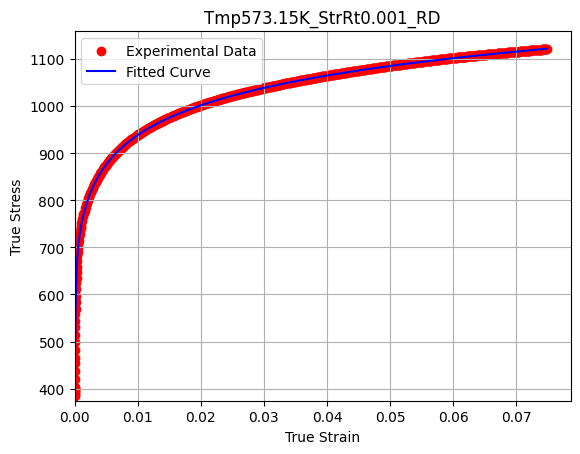

Fitted Parameters:
Alpha: -2.9454
A: 1875.7260
Epsilon_0: 0.0003
n: -0.0158
K0: 1685.1589
Q: 57.8916
Beta: 6729.2331

Error Metrics:
MSE: 2.9185
RMSE: 1.7084
MAE: 0.6316
R-squared: 0.9998


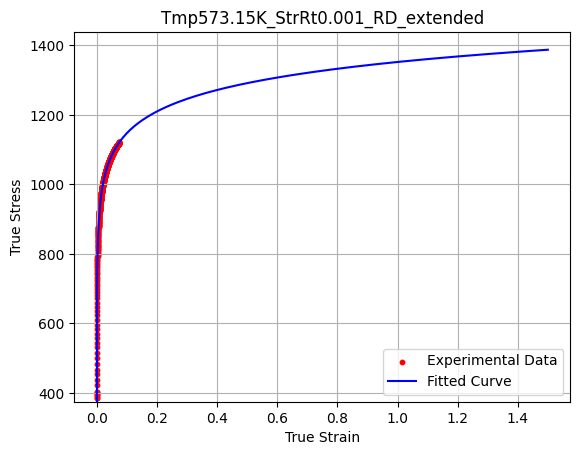

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


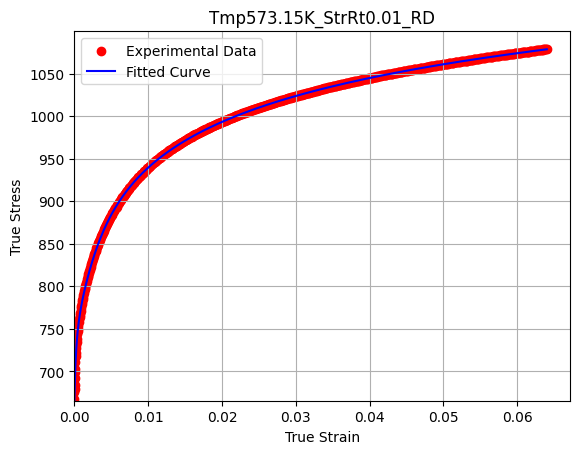

Fitted Parameters:
Alpha: -0.9967
A: 858.5526
Epsilon_0: 0.0002
n: -0.0687
K0: 1104.4467
Q: -46.8130
Beta: 1251.8091

Error Metrics:
MSE: 0.3470
RMSE: 0.5891
MAE: 0.3099
R-squared: 1.0000


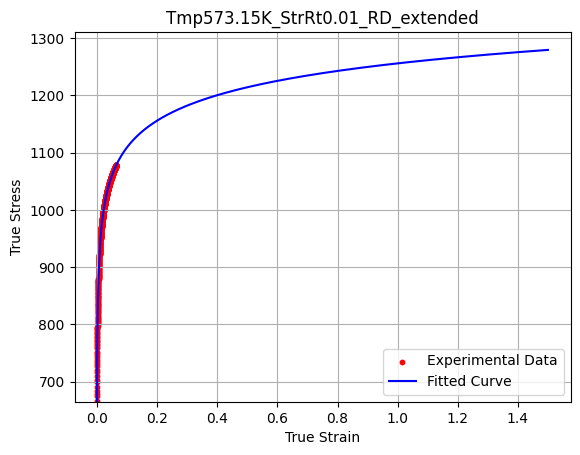

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


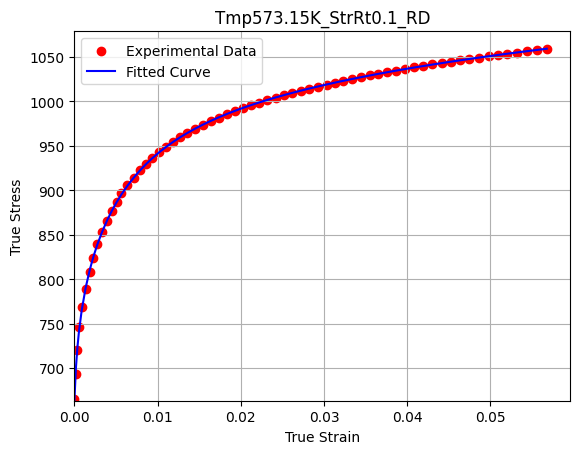

Fitted Parameters:
Alpha: 0.5966
A: 3398.4616
Epsilon_0: 0.0002
n: 0.0353
K0: -2075.5192
Q: 159.3440
Beta: 186.8205

Error Metrics:
MSE: 1.6225
RMSE: 1.2738
MAE: 0.5823
R-squared: 0.9998


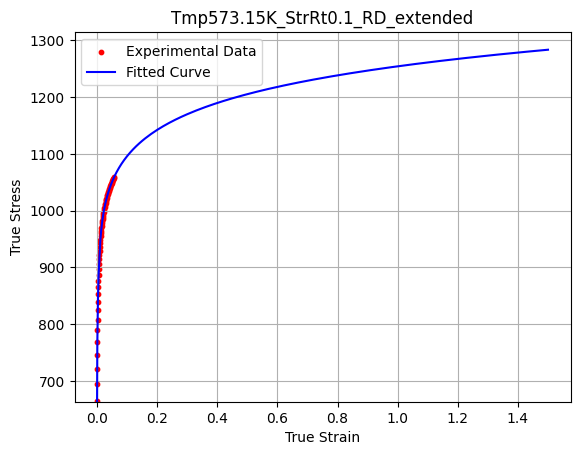

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


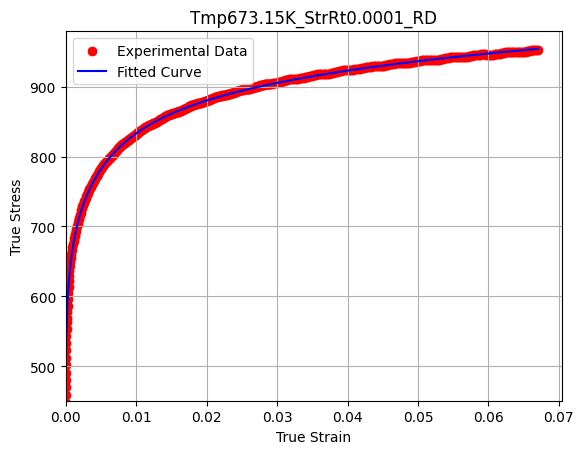

Fitted Parameters:
Alpha: 0.4608
A: 1071120.6963
Epsilon_0: 0.0000
n: 0.0001
K0: -913371.6424
Q: 73.1414
Beta: 183.6771

Error Metrics:
MSE: 5.3673
RMSE: 2.3167
MAE: 1.0788
R-squared: 0.9994


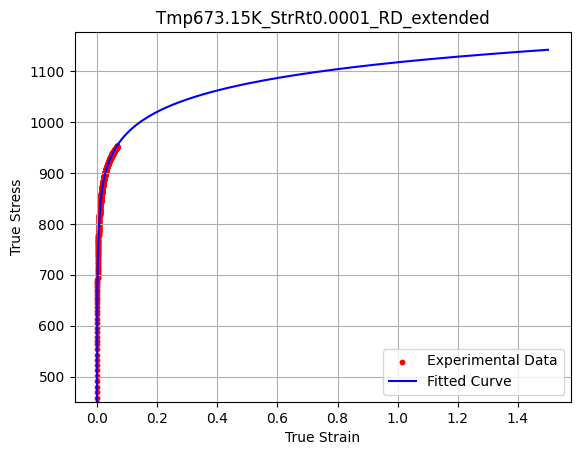

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


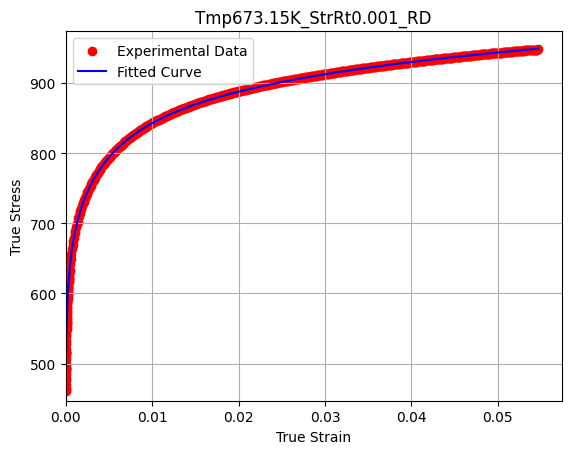

Fitted Parameters:
Alpha: 0.4578
A: 952214.0175
Epsilon_0: 0.0000
n: 0.0001
K0: -801826.5646
Q: 59.1985
Beta: 228.1955

Error Metrics:
MSE: 10.0890
RMSE: 3.1763
MAE: 1.0046
R-squared: 0.9993


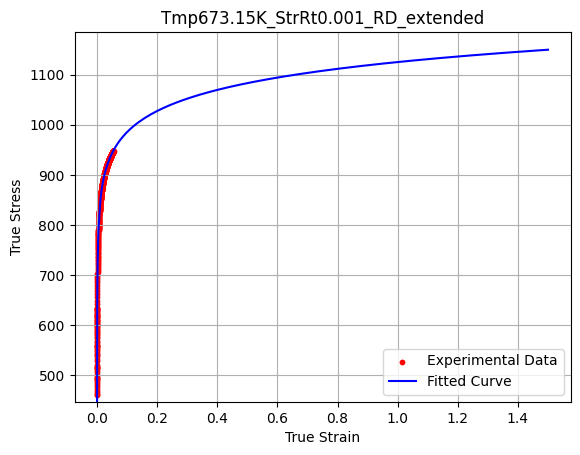

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


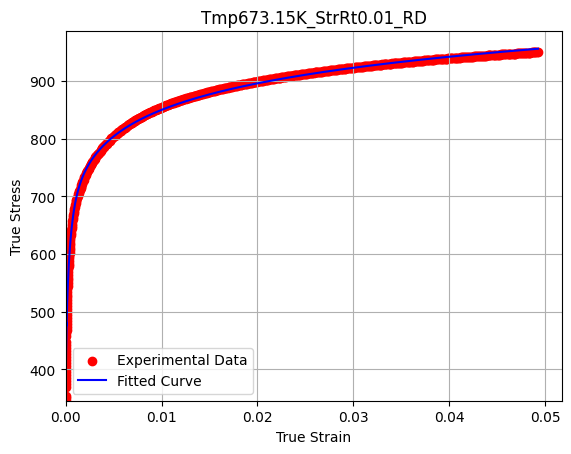

Fitted Parameters:
Alpha: 0.4358
A: 1402929.7554
Epsilon_0: 0.0000
n: 0.0001
K0: -1081807.2686
Q: 176.0583
Beta: 2373.7123

Error Metrics:
MSE: 27.3549
RMSE: 5.2302
MAE: 3.6027
R-squared: 0.9985


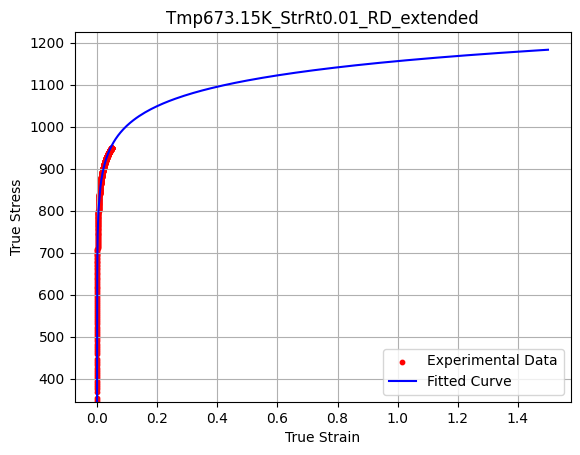

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_36379/2462314363.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


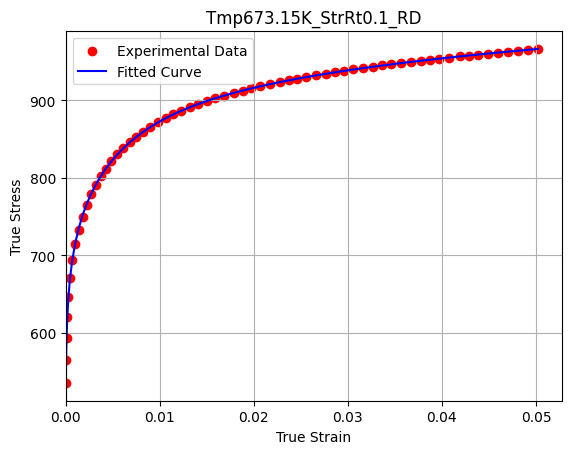

Fitted Parameters:
Alpha: 0.4645
A: 285977.1675
Epsilon_0: 0.0000
n: 0.0004
K0: -246088.9324
Q: 100.4017
Beta: 197.2025

Error Metrics:
MSE: 4.5256
RMSE: 2.1273
MAE: 0.8415
R-squared: 0.9997


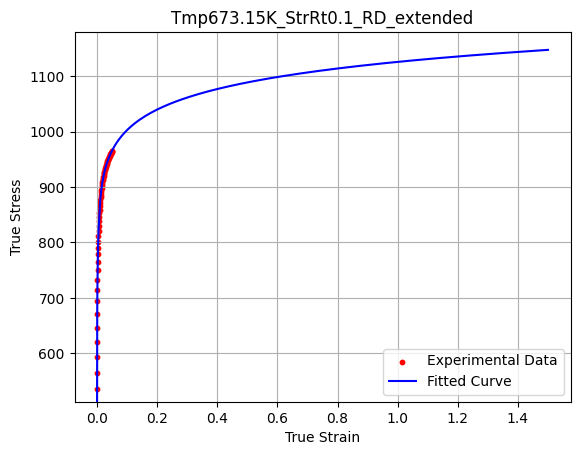

In [5]:
params = [] #store all parameters
params_name  = ['alpha', 'A', 'epsilon_0', 'n', 'k0', 'Q', 'beta']

conditions_77 = ['Tmp77.15K_StrRt0.0001_RD']
conditions_233 = ['Tmp233.15K_StrRt0.0001_RD']
conditions_298 = ['Tmp298.15K_StrRt0.0001_RD', 'Tmp298.15K_StrRt0.0001_DD', 'Tmp298.15K_StrRt0.0001_TD', 'Tmp298.15K_StrRt0.001_RD', 'Tmp298.15K_StrRt0.001_DD', 'Tmp298.15K_StrRt0.001_TD', 'Tmp298.15K_StrRt0.01_RD', 'Tmp298.15K_StrRt0.01_DD', 'Tmp298.15K_StrRt0.01_TD', 'Tmp298.15K_StrRt0.1_RD','Tmp298.15K_StrRt0.1_DD', 'Tmp298.15K_StrRt0.1_TD']
conditions_373 = ['Tmp373.15K_StrRt0.0001_RD', 'Tmp373.15K_StrRt0.001_RD', 'Tmp373.15K_StrRt0.01_RD', 'Tmp373.15K_StrRt0.1_RD']
conditions_473 = ['Tmp473.15K_StrRt0.0001_RD', 'Tmp473.15K_StrRt0.001_RD', 'Tmp473.15K_StrRt0.01_RD']
conditions_573 = ['Tmp573.15K_StrRt0.0001_RD', 'Tmp573.15K_StrRt0.001_RD', 'Tmp573.15K_StrRt0.01_RD', 'Tmp573.15K_StrRt0.1_RD']
conditions_673 = ['Tmp673.15K_StrRt0.0001_RD', 'Tmp673.15K_StrRt0.001_RD', 'Tmp673.15K_StrRt0.01_RD', 'Tmp673.15K_StrRt0.1_RD']
conditions = [conditions_77, conditions_233, conditions_298, conditions_373, conditions_473, conditions_573, conditions_673]
temps = ['77', '233', '298', '373', '473', '573', '673']

for i in range(len(conditions)):
    for condition in conditions[i]:
        params.append(analyze_sv_fit(f'data/Exp_FC_StrRtDpn_TmpDpn_Tmp{temps[i]}.csv', condition + '_E', condition + '_S', condition))

# r value fitting and generation

# Calculating ratio between RD, TD, DD, biaxial and generate files for stress-strain simulation

In [6]:
directions = ['RD', 'DD', 'TD']
ref_temp = '298.15'

strain_rates = [0.0001]
temps = ['77.15', '233.15']

strain_rates = [0.0001, 0.001, 0.01, 0.1]
temps = ['298.15', '373.15', '473.15', '573.15', '673.15']

#RD-biaxial ratio from Zinan file
data_biax = pd.read_csv('data/strain_extended.csv')
ratio_biax = data_biax['biaxial']/data_biax['RD']

for strain_rate in strain_rates:
    data_RD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_RD.csv')
    data_DD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_DD.csv')
    data_TD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_TD.csv')
    r = pd.read_csv(f'extended_r/R_values_StrainRate_{strain_rate}.csv')
    
    #RD-DD and RD-TD ratio
    ratio = [data_DD['Stress']/data_RD['Stress'], data_TD['Stress']/data_RD['Stress'], ratio_biax]

    #Generate TD, DD, biaxial for all conditions
    for temp in temps:
        #Read in RD data
        temp_RD = pd.read_csv(f'extended_curve/Tmp{temp}K_StrRt{strain_rate}_RD.csv')['Stress']
        
        df = pd.DataFrame({
        'strain': data_RD['Strain'],
        'RD': temp_RD,
        'DD': temp_RD * ratio[0],
        'TD': temp_RD * ratio[1],
        'biaxial': temp_RD * ratio[2],
        'r_RD': r['RD_R_value'],
        'r_DD': r['DD_R_value'],
        'r_TD': r['TD_R_value']
    })

        # Save the DataFrame to a CSV file
        output_file_path = f"inp_file/Tmp{temp}K_StrRt{strain_rate}.csv"  # Adjust the filename as needed
        df.to_csv(output_file_path, index=False)

In [7]:
strain_rate = 1
ref_strain_rate = 0.1
temp = '298.15'

data_RD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{ref_strain_rate}_RD.csv')
data_DD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{ref_strain_rate}_DD.csv')
data_TD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{ref_strain_rate}_TD.csv')
r = pd.read_csv(f'extended_r/R_values_StrainRate_{ref_strain_rate}.csv')

#RD-DD and RD-TD ratio
ratio = [data_DD['Stress']/data_RD['Stress'], data_TD['Stress']/data_RD['Stress'], ratio_biax]

temp_RD = pd.read_csv(f'extended_curve/Tmp{temp}K_StrRt{strain_rate}_RD.csv')['Stress']

df = pd.DataFrame({
    'strain': data_RD['Strain'],
    'RD': temp_RD,
    'DD': temp_RD * ratio[0],
    'TD': temp_RD * ratio[1],
    'biaxial': temp_RD * ratio[2],
    'r_RD': r['RD_R_value'],
    'r_DD': r['DD_R_value'],
    'r_TD': r['TD_R_value']
})

# Save the DataFrame to a CSV file
output_file_path = f"inp_file/Tmp{temp}K_StrRt{strain_rate}.csv"  # Adjust the filename as needed
df.to_csv(output_file_path, index=False)

In [ ]:
params_old = []
params_new = []
extended_strain = pd.read_csv("data/strain_extended.csv")['strain']
extended_strain = extended_strain[extended_strain <= 1.5]
extended_stress = swift_voce(extended_strain, *params)
plt.plot(extended_strain, extended_stress, label='Fitted Curve', color='blue')
plt.xlabel('True Strain')
plt.ylabel('True Stress')
plt.legend()
plt.grid(True)
plt.show()
